In [1]:
#plot from the large numpy file containing lots of runs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import numpy as np
#from tqdm import tqdm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib import cm
plt.rcParams.update({'font.size': 14, 'lines.markersize' : 4})
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import sys, os
import time, datetime
from datetime import timedelta
import pandas as pd
sys.path.append('/reg/neh/home/tdd14/modules/cart2pol/cart2pol')
import cart2pol
from cart2pol import PolarRebin
from torchrecon_funcs_clean import *

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
my_cmap = cm.get_cmap('jet')
xr = np.linspace(0, 1, 2000)
my_cmap = my_cmap(xr)
my_cmap[0:2,-1] = 0
my_cmap = ListedColormap(my_cmap)

In [20]:
#various functions for calculating stats (duration, etc)
def gaus(x, a, mu, sig):
    return a*1/sig/np.sqrt(2*np.pi)*np.exp(-0.5*((x-mu)/sig)**2)


def gaus_fit(t,spec):
    #spec = Et*Et.conj()
    popt, pcov = curve_fit(gaus,t,spec, bounds=([0.1, -50, 0.01], [100, 50, 30]))
    a, mu, sig = popt
    return a, mu, sig #FWHM is 2.355*sig

def FWHM(t, spec): 
    peakMax = np.max(spec)
    indMax = np.where(spec == peakMax)[0] #should be center since rolled
    if len(indMax)>1: indMax = np.max(indMax)
    t1 = 0
    t2 = 0
    
    for i in range(int(len(t)/2)):
        if t2 != 0 and t1 != 0:
            break
        if i < indMax: 
            if spec[i] >= 0.5*peakMax and t1 == 0:
                t1 = t[i]
            if spec[-i] >= 0.5*peakMax and t2 == 0:
                t2 = t[-i]  
    return t2-t1

def FWHM2(t, spec): 
    spec = spec/np.sum(spec)
    peakMax = np.max(spec)
    indMax = np.where(spec == peakMax)[0] 
    if len(indMax)>1: indMax = np.max(indMax)
    else: indMax = indMax[0]
    t1 = 0
    t2 = 0
    ind1 = 0
    ind2 = 0
    
    for i in range(int(len(t))):
        if t2 != 0 and t1 != 0:
            break
        if i < indMax:
            #print(i, np.trapz(spec[-i:]))
            
            if (np.trapz(spec[:i]) >= 0.25) & (t1 == 0):
                t1 = t[i]
                ind1 = i
            elif (np.trapz(spec[-(i+1):]) >= 0.25) & (t2 == 0):
                t2 = t[-(i+1)]  
                ind2 = -(i+1)
    return t2-t1 #, ind1, ind2

def peak_power(EtEt, ts,  gmd):
    EtEt = EtEt/np.sum(EtEt)
    dt_flat = np.trapz(EtEt,1e15*ts)/np.max(EtEt)
    #print(dt_flat)
    PP = gmd/dt_flat
    return PP

    

In [5]:
basesdir = '/reg/d/psdm/tmo/tmox51020/results/paris/circularpol_vNbases_dipole_Feb/'
PR = PolarRebin('/reg/d/psdm/tmo/tmox51020/results/paris/recon/PR_c32_r32_th32.h5') 


In [17]:
#name of file with consolidated output
fname = '/reg/d/psdm/tmo/tmox51020/results/paris/recon/torch_test_clean.npy'
dats = np.load(fname, allow_pickle = True)[()]

In [18]:
dat = dats['dat']
mask = dats['mask']
maskhm = dats['maskhm']
mdatname = dats['mdatname']
specdatname = dats['specdatname']
gfsig = dats['gfsig']
eshift = dats['eshift']
sc = dats['sc']
gfcart = 0.25
thresh = dats['thresh'] 
runnum = dats['runnum']
pixpereV = dats['pixpereV']
print(mdatname)

/cds/home/p/paris/cVMI/examples/Ms_test_clean.npy


In [9]:
mdat= np.load(mdatname , allow_pickle = True)[()]
specdat = np.load(specdatname, allow_pickle = True)[()]
#gds is a file of the shot gmd data
gds = np.load(mdatname.split('Ms')[-0]+'GDs'+mdatname.split('Ms')[-1],allow_pickle=True)[()]

In [10]:
Ups = np.unique(dat['Up'])
print(Ups)

[0.4 1. ]


In [11]:
Bps = []
alphas = []
vNaxiss = []
alphaws = []
N_w = 6
N_t = 6
Nb = N_w*N_t
for i in range(len(Ups)):
    Np = 128
    Up = Ups[i]  
    filename = 'Bpbasis_Np' + str(Np) + '_Nw' + str(N_w) +'_Nt' + str(N_t) + '_Up' + str(Up)+'.npy'
    print(filename)
    br = np.load(basesdir+filename, allow_pickle=True)
    Breal = br[()]['Breal']
    Bimag = br[()]['Bimag']
    breal = br[()]['breal']
    bimag = br[()]['bimag']
    vNaxis = br[()]['vNaxis']
    alpha = br[()]['alpha']

    
    tempr = np.zeros((Breal.shape[0], 64**2))
    tempi = np.zeros((Breal.shape[0], 64**2))
    for i in range(len(Breal)):
        tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
        tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

    Breal = tempr
    Bimag = tempi

    alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    for i in range(len(alphw)):
        f = interp1d(vNaxis['t_sample'], alpha['t_sample'][i], fill_value = 0, bounds_error = False)
        N = 2801 #1024
        ts = np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], N)
        alphw[i] = np.fft.ifftshift(np.fft.ifft(f(ts)))

    Np = 64
    for j in range(Breal.shape[0]):
        temp=np.reshape(Breal[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Breal[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
        temp=np.reshape(Bimag[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Bimag[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))

    Bp_basis = Breal+1j*Bimag

    Bps.append(Bp_basis)
    alphas.append(alpha)
    vNaxiss.append(vNaxis)
    alphaws.append(alphw)

Bpbasis_Np128_Nw6_Nt6_Up0.4.npy
Bpbasis_Np128_Nw6_Nt6_Up1.0.npy


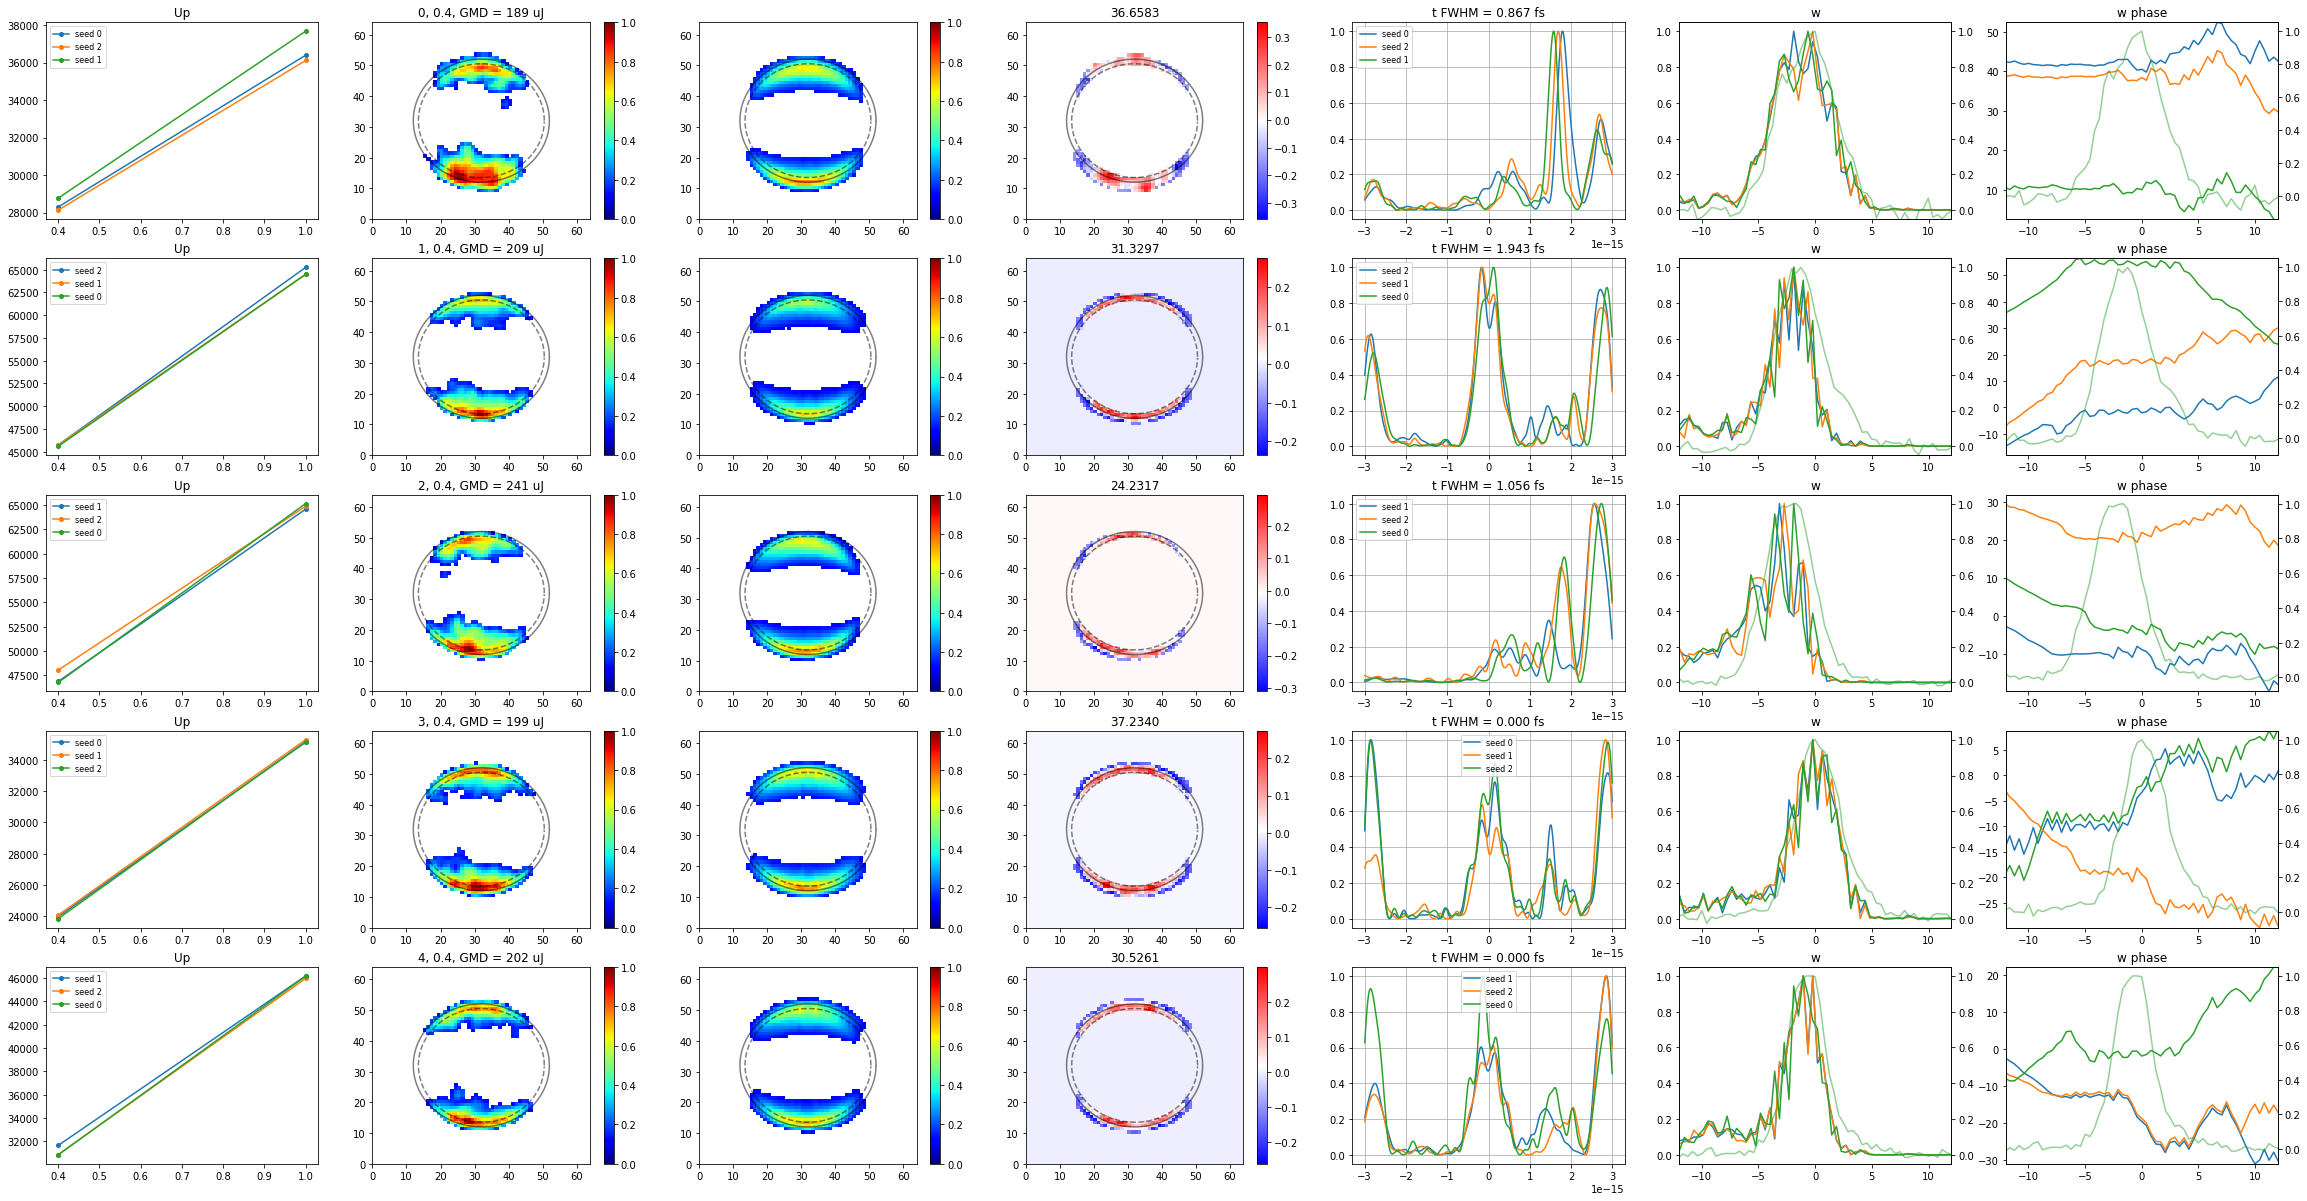

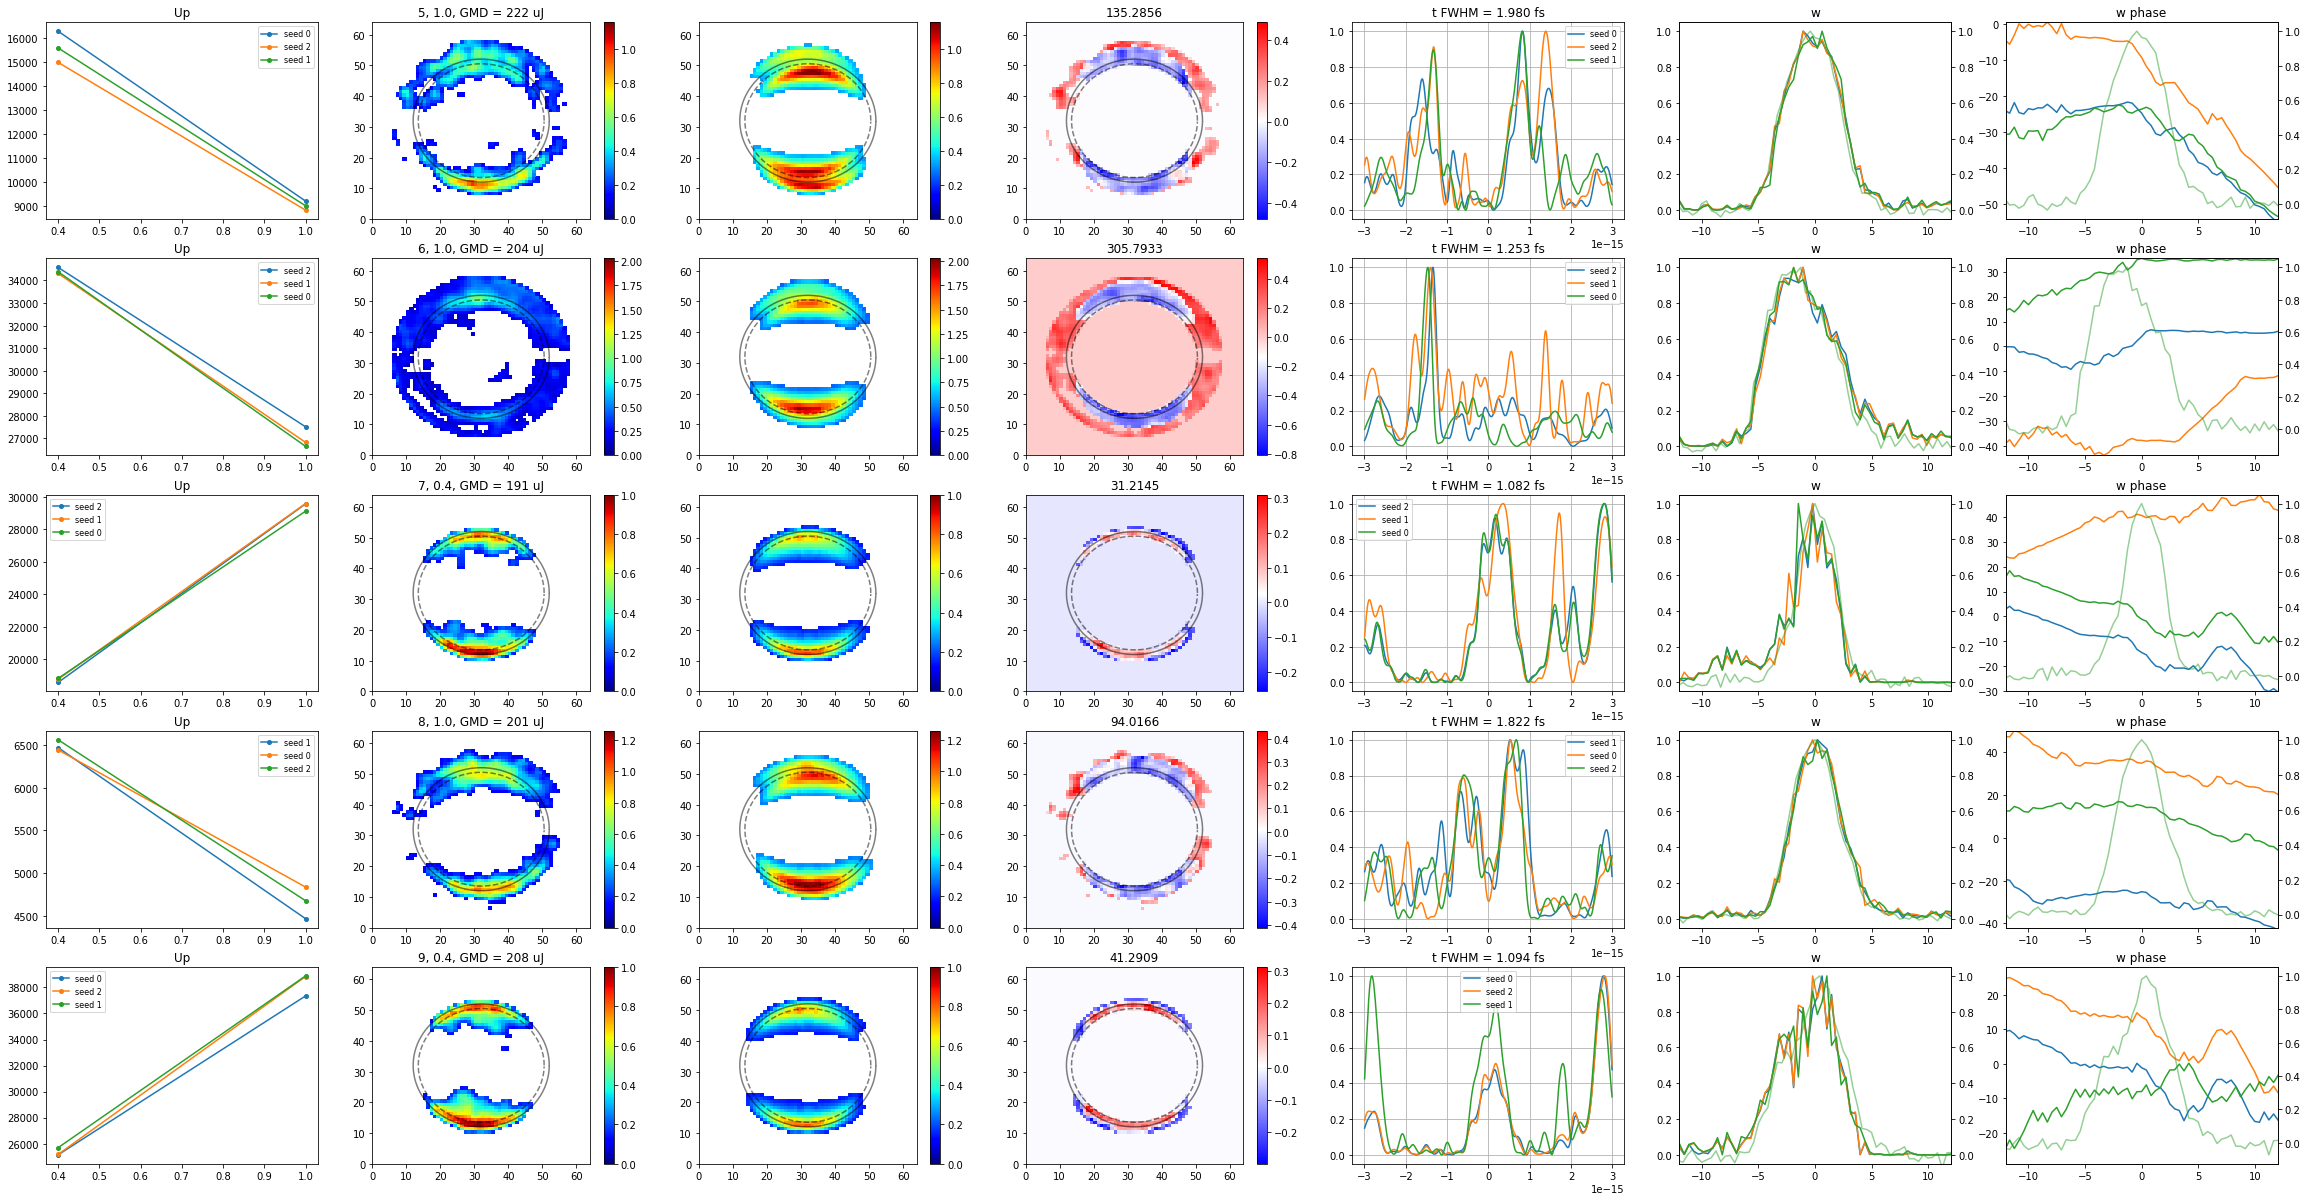

In [12]:
#plot each shot to check fit params/goodness by eye
fwhms = []
std_t = []
ups_b = []
fwhms_avg = []
fwhms_maxs = []
fwhms2_maxs = []
eshift = np.unique(dat['eshift'])
IDs = np.unique(dat['ID'])
thresh = dats['thresh']
for k in range(int(np.ceil(len(IDs)/5))):
    fig,axs = plt.subplots(nrows = 5, ncols =7, figsize = (40,21))
    for l in range(5):
        uplook = dat[(dat['ID'] == IDs[k*5+l])]['Up'][np.argmin(dat[(dat['ID'] == IDs[k*5+l])]['costs'][:,-1])]
        u = int(np.where(Ups == uplook)[0])
        seed_order = np.argsort(dat[(dat['ID'] == IDs[k*5+l])&(dat['Up'] == uplook)]['costs'][:,-1])
        seeds = np.unique(dat[(dat['ID'] == IDs[k*5+l])&(dat['Up'] == uplook)]['seed'])
        #seed_order = np.arange(len(seeds))
        duration = []
        ets = []
        
        for ss in range(len(seeds)):   
        
            x = dat[(dat['ID'] == IDs[k*5+l])&(dat['seed'] == seeds[seed_order[ss]])]['Up']
            y= dat[(dat['ID'] == IDs[k*5+l])&(dat['seed'] == seeds[seed_order[ss]])]['costs'][:,-1]
            #y= dat[(dat['ID'] == IDs[k])]['costM'][:,-1]
            axs[l][0].plot(x[np.argsort(x)], y[np.argsort(x)], '-o', label = 'seed %1.0f' %seeds[seed_order[ss]])
            
            if ss == len(seeds)-1:
                axs[l][0].set_title('Up')
                axs[l][0].legend(fontsize = 8)
        
        
        Bp = Bps[u]
        vNaxis = vNaxiss[u]
        alpha = alphas[u]
        alphw = alphaws[u]
        ts= vNaxis['t_sample']
        
        t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) 
        t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)


        m = mdat[IDs[k*5+l]]
        spec = specdat[IDs[k*5+l]]
        #spec = np.roll(spec,30)
        m = m/np.sum(m)
        N = 2801
        xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis['t_sample'][0])/2
       # xf = np.arange(-N/2+1/2,N/2+1/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
        eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
        #Interpolate spec outside of the loop to match eV
        xeV = pix_2_eV(np.arange(1024), pixpereV = pixpereV, spectra_hw0 = 0, spectra_pix0 = 512)
        xeV = xeV - eshift#3 #know this from previous calibration

        for s in range(len(seeds)):
            
            if len(seeds)>1:
                Q = np.squeeze(dat[(dat['ID'] == IDs[k*5+l])&(dat['Up'] == uplook)]['Qs'][seeds[seed_order[s]],:])
            else:
                Q = np.squeeze(dat[(dat['ID'] == IDs[k*5+l])&(dat['Up'] == uplook)]['Qs'])
            N_basis = 36
            eVshift_idx = 0
            Q1=Q[0:N_basis]
            Q1=np.reshape(Q1,[1,N_basis])
            Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
            Q2=np.reshape(Q2,[1,N_basis])
            Qguess=Q1+1j*Q2
            Qguess=np.reshape(Qguess,[N_basis,1])
            Mgr=np.real(np.matmul(np.matmul(Qguess,Qguess.conj().transpose()).transpose().flatten(),Bp))
            Mgr=Mgr/np.sum(Mgr)
            Mgr[Mgr<thresh] = 0
            Mgr=Mgr/np.sum(Mgr)

            alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) ##take out carrier
            #alpha_t = alpha['t']/np.max(np.abs(alpha['t'])) #alpha_t = alpha_t*np.exp(-1.j*(energy_x)/hbar*np.tile(vNaxis['t'],(N_basis,1)))
            Et = np.squeeze(np.matmul(Qguess.T,alpha_t))
            
            f = interp1d(vNaxis['t_sample'],Et, fill_value = 0, bounds_error = False)
            Et_l = f(np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], len(vNaxis['t_sample'])))
            aghh = np.argmax(np.abs(Et_l))
            Ew = np.fft.ifftshift(np.fft.ifft(np.roll(Et_l,-aghh))) #need this to get imag part, must be evenly spaced
            #Ew = np.squeeze(np.matmul(Qguess.T,alphw))
            EwEw = np.real(Ew*Ew.conj())
            EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
            EwEw = EwEw/np.max(EwEw)
            wphase = np.unwrap(np.angle(Ew))
            wphase = wphase - np.mean(wphase)
            Ew = np.squeeze(np.matmul(Qguess.T,alphw)) 
            EwEw = np.real(Ew*Ew.conj())
            EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
            EwEw = EwEw/np.max(EwEw)


#             aghh = np.argmax(np.abs(Et))
#             Ew = np.fft.ifftshift(np.fft.ifft(np.roll(Et,-aghh))) #need this to get imag part
#             #Ew = np.squeeze(np.matmul(Qguess.T,alphw))
#             EwEw = np.real(Ew*Ew.conj())
#             EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
#             EwEw = EwEw/np.max(EwEw)
#             wphase = np.unwrap(np.angle(Ew))
#             wphase = wphase - np.mean(wphase)

            phis = np.linspace(0,359,100)*np.pi/180
            if s == 0:

                pscale = 1/np.max(m/np.sum(m*mask))
                Mt = m/np.sum(m*mask)*pscale
                Mp = pscale*np.reshape(Mgr/np.sum(mask*np.reshape(Mgr, [64,64])), [64,64])
                #Mp = Mp/np.max(Mp)
                #tosave[str(k) + '_Q'] = Q
                #tosave[str(k) + '_Up'] = uplook
                p =axs[l][1].pcolormesh(Mt, cmap = my_cmap,vmax = np.max([np.max(Mp),1]))
                axs[l][1].plot(32+ 20*np.cos(phis), 32+ 20*np.sin(phis), 'k-', alpha = 0.5)
                axs[l][1].plot(32+ 18.5*np.cos(phis), 32+ 18.5*np.sin(phis), 'k--', alpha = 0.5)
                plt.colorbar(p, ax = axs[l][1])
                axs[l][1].set_title(str(IDs[k*5+l])+', '+str(uplook)+', GMD = %1.0f uJ' %(1000*gds[IDs[k*5+l]]))
                ups_b.append(uplook)

                p =axs[l][2].pcolormesh(Mp, cmap = my_cmap,vmax = np.max([np.max(Mp),1]))#, vmin = np.min(m), vmax = np.max(m))
                plt.colorbar(p, ax = axs[l][2])
                phis = np.linspace(0,359,100)*np.pi/180
                axs[l][2].plot(32+ 20*np.cos(phis), 32+ 20*np.sin(phis), 'k-', alpha = 0.5)
                axs[l][2].plot(32+ 18.5*np.cos(phis), 32+ 18.5*np.sin(phis), 'k--', alpha = 0.5)

                p = axs[l][3].pcolormesh((Mt-Mp)*mask, cmap = 'bwr')
                axs[l][3].set_title('%1.4f' %np.sum(np.abs(Mt-Mp)*mask))
                #p = axs[2].pcolormesh(m-np.reshape(Mgr, [64,64]), cmap = 'bwr')
                axs[l][3].plot(32+ 20*np.cos(phis), 32+ 20*np.sin(phis), 'k-', alpha = 0.5)
                axs[l][3].plot(32+ 18.5*np.cos(phis), 32+ 18.5*np.sin(phis), 'k--', alpha = 0.5)
                plt.colorbar(p, ax = axs[l][3])

                f = interp1d(xeV,spec, bounds_error=False, fill_value = 0)
                spec_in = f(eV[1340:-1340])
                ############# spec cal
                xxx1 = np.arange(len(spec_in))
                f = interp1d(xxx1, spec_in, fill_value = 0, bounds_error = False)
                xs = np.linspace((xxx1[0] -np.argmax(spec_in)), (xxx1[-1]-np.argmax(spec_in)), len(xxx1))+np.argmax(spec_in)
                spec_in = f(xs)
                #########

                spec_in=spec_in/np.max(spec_in)
                ax1 = axs[l][6].twinx()
                ax1.plot(eV[1340:-1340], spec_in, color= 'tab:green', alpha = 0.5)
                ax = axs[l][5].twinx()
                ax.plot(eV[1340:-1340], spec_in, color= 'tab:green', alpha = 0.5)


            axs[l][5].set_title('w')
            #axs[l][4].set_title('t')
            axs[l][5].plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), np.squeeze(EwEw))
            ax.set_ylim(axs[l][5].get_ylim())
            EtEt = np.abs(Et*Et.conj())
            EtEt = EtEt/np.max(EtEt)
            axs[l][4].plot(ts[t1:t2], EtEt[t1:t2],label = 'seed %1.0f' %seeds[seed_order[s]])
            axs[l][4].grid()
            #axs[l][4].set_xlim(-4e-15,4e-15)
            
            roll_to = np.argmax(EtEt[t1:t2])
            # a,mu,sig = gaus_fit(ts*1e15,np.roll(EtEt, int(len(EtEt)/2)-roll_to))
            # duration.append(2.355*sig)
            
            duration.append(FWHM(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to)))
            ets.append(EtEt)
            
            axs[l][6].set_title('w phase')

            axs[l][6].plot(eV[1340-eVshift_idx:-1340-eVshift_idx], wphase[1340-eVshift_idx:-1340-eVshift_idx])
            if s == 0: ymin,ymax = np.min(wphase[1340-eVshift_idx:-1340-eVshift_idx][30:90]),np.max(wphase[1340-eVshift_idx:-1340-eVshift_idx][30:90])
            if s>0: 
                if np.min(wphase[1340-eVshift_idx:-1340-eVshift_idx][30:90]) < ymin: ymin = np.min(wphase[1340-eVshift_idx:-1340-eVshift_idx][30:90])
                if np.max(wphase[1340-eVshift_idx:-1340-eVshift_idx][30:90]) > ymax: ymax = np.max(wphase[1340-eVshift_idx:-1340-eVshift_idx][30:90])
            axs[l][6].set_ylim(ymin,ymax)
            if s == len(seeds)-1: axs[l][4].legend(fontsize = 8)
        axs[l][4].set_title('t FWHM = %1.3f fs' %np.mean(duration)) 
        axs[l][5].set_xlim(-12,12)
        axs[l][6].set_xlim(-12,12)
        EtEtm = np.mean(ets,axis = 0)
        EtEtmax = np.max(ets,axis = 0)
        fwhms2_maxs.append(FWHM2(ts[t1:t2]*1e15,np.roll(EtEtmax[t1:t2], int(len(EtEtmax[t1:t2])/2)--np.argmax(EtEtmax[t1:t2]))))
        fwhms.append(np.mean(duration))
        fwhms_avg.append(FWHM(ts*1e15, np.roll(EtEtm[t1:t2], int(len(EtEtm[t1:t2])/2)-np.argmax(EtEtm[t1:t2]))))
        fwhms_maxs.append(FWHM(ts*1e15, np.roll(EtEtmax[t1:t2], int(len(EtEtm[t1:t2])/2)-np.argmax(EtEtm[t1:t2]))))
        std_t.append(np.sum(np.std(np.array(ets),axis = 0)))
    plt.show()

In [13]:
std_t = np.array(std_t)
ups_b = np.array(ups_b)
fwhms = np.array(fwhms)
gds = np.array(gds)

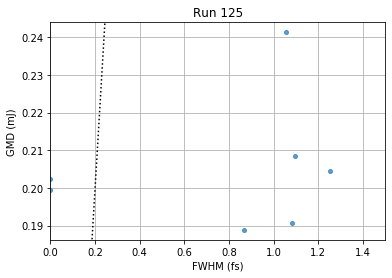

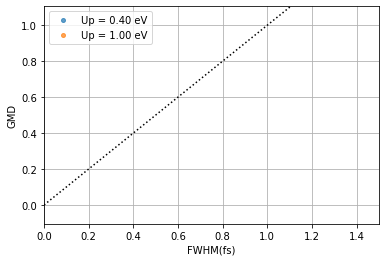

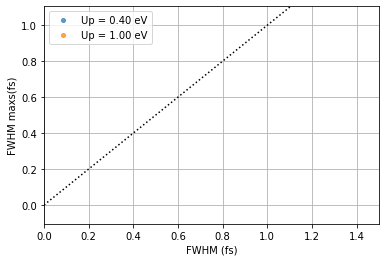

In [21]:
#plot overall run stats
plt.plot(fwhms, gds, 'o', alpha = 0.7)
plt.xlabel('FWHM (fs)')
plt.ylabel('GMD (mJ)')
plt.xlim(0,1.5)
plt.ylim(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1])
plt.plot([0,2],[0,2], 'k:')
plt.grid()
plt.title('Run %1.0f' %runnum)
plt.show()

for u in np.unique(ups_b):
    std_thresh = 90
    plt.plot(fwhms[(ups_b == u) & (std_t < std_thresh)], gds[(ups_b == u)& (std_t < std_thresh)], 'o', alpha = 0.7, label = 'Up = %1.2f eV' %u)
plt.legend()
plt.ylim(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1])
plt.plot([0,2],[0,2], 'k:')
plt.xlabel('FWHM(fs)')
plt.ylabel('GMD')
plt.xlim(0,1.5)
plt.grid()
plt.show()

for u in np.unique(ups_b):
    
    plt.plot(fwhms[(ups_b == u) & (std_t < std_thresh)], fwhms_maxs[(ups_b == u)& (std_t < std_thresh)], 'o', alpha = 0.7, label = 'Up = %1.2f eV' %u)
plt.legend()
plt.ylim(plt.gca().get_ylim()[0],plt.gca().get_ylim()[1])
plt.plot([0,2],[0,2], 'k:')
plt.ylabel('FWHM maxs(fs)')
plt.xlabel('FWHM (fs)')
plt.xlim(0,1.5)
plt.grid()
plt.show()


In [28]:
l =13
datall = np.ndarray(len(dat), dtype = [('run', int),('seed', int),('ID', int),('Up', float), ('Qs', float, 2*36-1),\
                                      ('costs', float,l), ('costM', float,l), 
                                      ('std_t', float), ('fwhm2', float), ('fwhm', float),\
                                      ('gmd', float), ('Upb', bool), ('peak_power', float), ('Qb', bool),\
                                        ])
eshift = np.unique(dat['eshift'])
IDs = np.unique(dat['ID'])
thresh = dats['thresh']

numseed = len(np.unique(dat['seed']))
numUp = len(Ups)

ii = 0

for k in range(len(IDs)):
    Ups_i = np.unique(dat[(dat['ID'] == IDs[k])]['Up'])
    up_order = []
    for u in range(len(Ups_i)):
        up_order.append(np.min(dat[(dat['ID'] == IDs[k])&(dat['Up'] == Ups_i[u])]['costs'][:,-1]))

    up_order = np.argsort(up_order)
    for u in range(len(Ups_i)):
        uplook = Ups_i[up_order[u]]

        seeds = np.unique(dat[(dat['ID'] == IDs[k])&(dat['Up'] == uplook)]['seed'])
        ets = []

        Bp = Bps[up_order[u]]
        vNaxis = vNaxiss[up_order[u]]
        alpha = alphas[up_order[u]]
        alphw = alphaws[up_order[u]]
        ts = vNaxis['t_sample']
        t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) 
        t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)

        m = mdat[IDs[k]]
        #spec = specdat[IDs[k]]
        #spec = np.roll(spec,30)
        m = m/np.sum(m)
        # N = 2801
        # xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis['t_sample'][0])/2
        # eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
        # #Interpolate spec outside of the loop to match eV
        # xeV = pix_2_eV(np.arange(1024), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)
        # xeV = xeV - eshift#3 #know this from previous calibration

        for s in range(len(seeds)):
            dat0 = dat[(dat['ID'] == IDs[k])&(dat['Up'] == uplook)&(dat['seed']== seeds[s])]
            Q = np.squeeze(dat0['Qs'])

            #datall[k*numUp*numseed+u*numseed+s]['seed'] = seeds[s]
            datall[ii]['seed'] = seeds[s]
            datall[ii]['Qs'] = Q
            datall[ii]['costs'] = dat0['costs']
            datall[ii]['costM'] = dat0['costM']
            datall[ii]['ID'] = IDs[k]
            datall[ii]['run'] = runnum
            datall[ii]['Up'] = uplook
            datall[ii]['gmd'] = gds[k]


            N_basis = 36
            eVshift_idx = 0
            Q1=Q[0:N_basis]
            Q1=np.reshape(Q1,[1,N_basis])
            Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
            Q2=np.reshape(Q2,[1,N_basis])
            Qguess=Q1+1j*Q2
            Qguess=np.reshape(Qguess,[N_basis,1])
            Mgr=np.real(np.matmul(np.matmul(Qguess,Qguess.conj().transpose()).transpose().flatten(),Bp))
            Mgr=Mgr/np.sum(Mgr)
            Mgr[Mgr<thresh] = 0
            Mgr=Mgr/np.sum(Mgr)

            alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) ##take out carrier
            #alpha_t = alpha['t']/np.max(np.abs(alpha['t'])) #alpha_t = alpha_t*np.exp(-1.j*(energy_x)/hbar*np.tile(vNaxis['t'],(N_basis,1)))
            Et = np.squeeze(np.matmul(Qguess.T,alpha_t))

            f = interp1d(vNaxis['t_sample'],Et, fill_value = 0, bounds_error = False)
            Et_l = f(np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], len(vNaxis['t_sample'])))
            aghh = np.argmax(np.abs(Et_l))
            Ew = np.fft.ifftshift(np.fft.ifft(np.roll(Et_l,-aghh))) #need this to get imag part, must be evenly spaced
            #Ew = np.squeeze(np.matmul(Qguess.T,alphw))
            EwEw = np.real(Ew*Ew.conj())
            EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
            EwEw = EwEw/np.max(EwEw)
            wphase = np.unwrap(np.angle(Ew))
            wphase = wphase - np.mean(wphase)
            Ew = np.squeeze(np.matmul(Qguess.T,alphw)) 
            EwEw = np.real(Ew*Ew.conj())
            EwEw = EwEw[1340-eVshift_idx:-1340-eVshift_idx]
            EwEw = EwEw/np.max(EwEw)


            pscale = 1/np.max(m/np.sum(m*mask))
            Mt = m/np.sum(m*mask)*pscale
            Mp = pscale*np.reshape(Mgr/np.sum(mask*np.reshape(Mgr, [64,64])), [64,64])
                #Mp = Mp/np.max(Mp)
                #tosave[str(k) + '_Q'] = Q
                #tosave[str(k) + '_Up'] = uplook

            if u == 0: datall[ii]['Upb'] = True
            else: datall[ii]['Upb'] = False


            EtEt = np.abs(Et*Et.conj())
            EtEt = EtEt/np.max(EtEt)

            roll_to = np.argmax(EtEt[t1:t2])
            datall[ii]['fwhm']= FWHM(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to))
            datall[ii]['fwhm2']=FWHM2(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to))
            # a,mu,sig = gaus_fit(ts*1e15,np.roll(EtEt, int(len(EtEt)/2)-roll_to))
            # duration.append(2.355*sig)

            #datall[k*numseed+s]['fwhm'](FWHM(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to)))

            ets.append(EtEt)
            ii+=1
            
    #     EtEtm = np.mean(ets,axis = 0)
    #     EtEtmax = np.max(ets,axis = 0)

        #fwhms2_maxs.append(FWHM2(ts[t1:t2]*1e15,np.roll(EtEtmax[t1:t2], int(len(EtEtmax[t1:t2])/2)--np.argmax(EtEtmax[t1:t2]))))
        #fwhms.append(np.mean(duration))
        #fwhms_avg.append(FWHM(ts*1e15, np.roll(EtEtm[t1:t2], int(len(EtEtm[t1:t2])/2)-np.argmax(EtEtm[t1:t2]))))
        #fwhms_maxs.append(FWHM(ts*1e15, np.roll(EtEtmax[t1:t2], int(len(EtEtm[t1:t2])/2)-np.argmax(EtEtm[t1:t2]))))
        std_t=(np.sum(np.std(np.array(ets),axis = 0)))
        pp = peak_power(np.mean(ets,axis= 0),ts,gds[k])
        
        likely = []
        for n in range(len(ets)):
            datall[ii-len(ets)+n]['std_t'] = std_t
            datall[ii-len(ets)+n]['peak_power'] = pp
            dot = []
            for l in range(len(ets)):
                if n != l:
                    dot.append(np.dot(ets[n]/np.linalg.norm(ets[n]),ets[l]/np.linalg.norm(ets[l])))
            likely.append(np.sum(dot))
        
        for n in range(len(likely)):
            if n == np.argmax(likely):
                datall[ii-len(likely)+n]['Qb'] = True
            else: datall[ii-len(likely)+n]['Qb'] = False
 

(array([ 3.,  3.,  6., 24.,  6.,  0.,  3.,  9.,  3.,  3.]),
 array([ 41.04074149,  59.46494563,  77.88914977,  96.31335391,
        114.73755804, 133.16176218, 151.58596632, 170.01017045,
        188.43437459, 206.85857873, 225.28278287]),
 <a list of 10 Patch objects>)

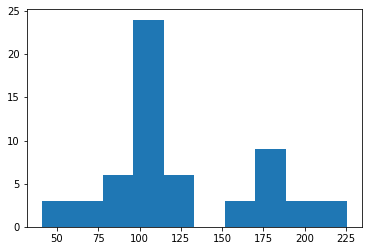

In [31]:
plt.hist(datall['std_t'])

3


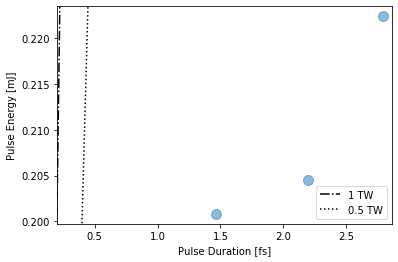

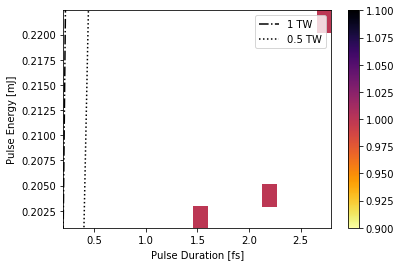

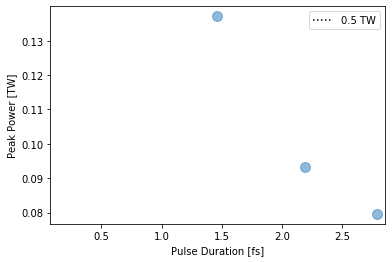

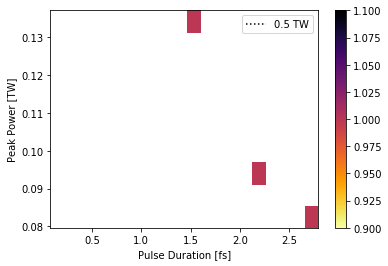

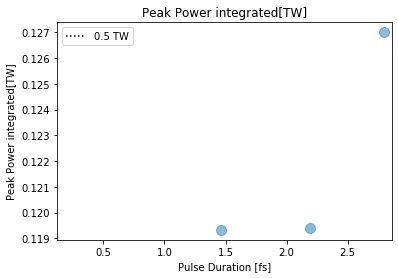

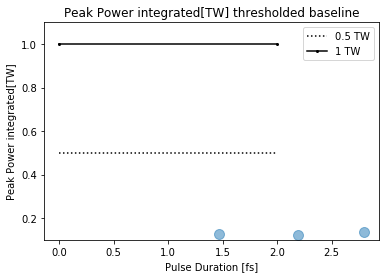

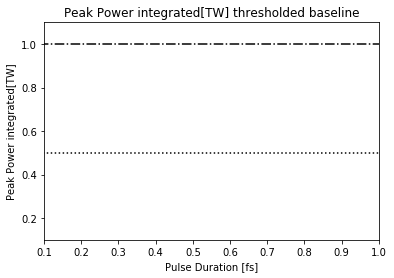

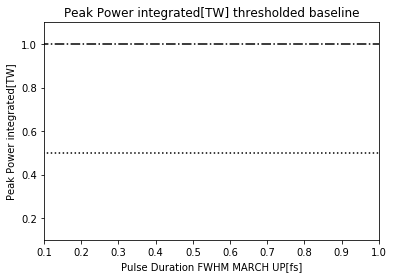

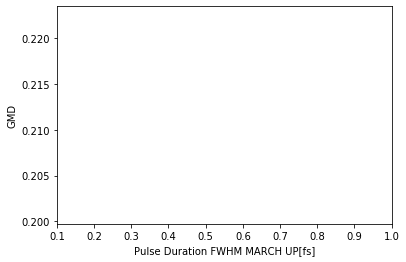

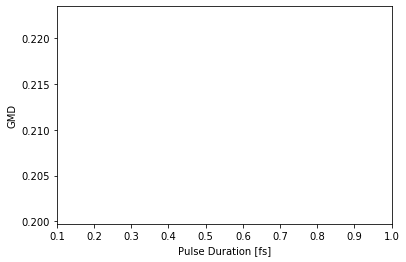

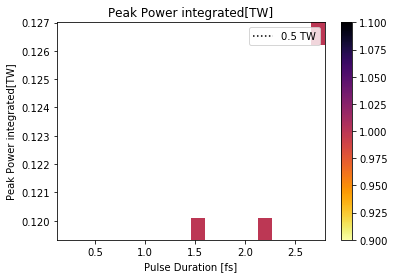

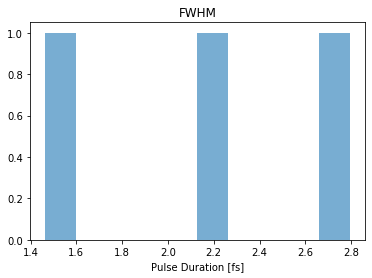

In [33]:
cut = (datall['Upb'] == True) & (datall['Up'] > 0.1) & (datall['std_t']<400) #cut on goodness of fit
gmds = []
ids = []
fwhms = []
fwhms2 = []
upss = []
pps = []
pps_trunc = []
runl =[]
t1 = 0
t2 = -1
ts = vNaxis['t_sample']
for r,rname in enumerate(np.unique(datall[cut]['run'])):
    
    for i, idx in enumerate(np.unique(datall[cut]['ID'])):
        test = datall[cut & (datall['ID'] == idx)& (datall['run'] == rname)]
        if len(test)>0:
            if (np.min(datall[datall['run'] == rname]['Up']) < np.min(test['Up'])):
                if len(test[test['Qb']])>0:

                    Q = np.squeeze(test[test['Qb']]['Qs'])
                    N_basis = 36
                    eVshift_idx = 0
                    Q1=Q[0:N_basis]
                    Q1=np.reshape(Q1,[1,N_basis])
                    Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
                    Q2=np.reshape(Q2,[1,N_basis])
                    Qguess=Q1+1j*Q2
                    Qguess=np.reshape(Qguess,[N_basis,1])
                    alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) ##take out carrier
                    #alpha_t = alpha['t']/np.max(np.abs(alpha['t'])) #alpha_t = alpha_t*np.exp(-1.j*(energy_x)/hbar*np.tile(vNaxis['t'],(N_basis,1)))
                    Et = np.squeeze(np.matmul(Qguess.T,alpha_t))

                    EtEt = np.abs(Et*Et.conj())
                    EtEt = EtEt/np.max(EtEt)

                    roll_to = np.argmax(EtEt[t1:t2])

                    ids.append(int(np.mean(test['ID'])))
                    gmds.append(np.mean(test['gmd']))
                    fwhms.append(np.mean(test['fwhm']))
                    #fwhms2.append(np.mean(test['fwhm2']))
                    upss.append(test['Up'][0]) #np.mean(test['Up']))
                    runl.append(rname)

                    pps.append(peak_power(EtEt,ts, test[0]['gmd']))
                    EtEt[EtEt<0.1*np.max(EtEt)] = 0
                    pps_trunc.append(peak_power(EtEt,ts,test[0]['gmd']))
                    fwhms2.append(FWHM2(ts[t1:t2]*1e15,np.roll(EtEt[t1:t2], int(len(EtEt[t1:t2])/2)-roll_to)))
    
print(len(fwhms2))

plt.plot(fwhms2, gmds, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Pulse Energy [mJ]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0,2], 'k-.',label = '1 TW')
plt.plot([0,2],[0,1], 'k:',label = '0.5 TW')
plt.legend()
plt.show()
    
plt.hist2d(fwhms2, gmds, cmap = 'inferno_r', cmin = 1) #, bins = 30)
plt.colorbar()
plt.ylabel('Pulse Energy [mJ]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0,2], 'k-.',label = '1 TW')
plt.plot([0,2],[0,1], 'k:',label = '0.5 TW')
plt.legend()
plt.show()

gmds = np.array(gmds)
fwhms = np.array(fwhms)
fwhms2 = np.array(fwhms2)
upss = np.array(upss)
pps = np.array(pps)
pps_trunc = np.array(pps_trunc)


plt.plot(fwhms2, gmds/fwhms2, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power [TW]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.show()

plt.hist2d(fwhms2, gmds/fwhms2, cmap = 'inferno_r', cmin = 1) #, bins = 30)
plt.colorbar()
plt.ylabel('Peak Power [TW]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.show()

plt.plot(fwhms2, pps, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.show()

plt.plot(fwhms2, pps_trunc, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration [fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),np.max((plt.gca().get_ylim()[1],[1])))
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.ylim(0.1,1.1)
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.plot([0,2],[1,1], 'k.-', label = '1 TW')
plt.legend()
plt.show()


plt.plot(fwhms2, pps_trunc, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration [fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),np.max((plt.gca().get_ylim()[1],[1])))
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.ylim(0.1,1.1)
plt.xlim(0.1,1)
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.plot([0,2],[1,1], 'k-.', label = '1 TW')
#plt.legend()
plt.show()

plt.plot(fwhms, pps_trunc, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration FWHM MARCH UP[fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),np.max((plt.gca().get_ylim()[1],[1])))
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.ylim(0.1,1.1)
plt.xlim(0.1,1)
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.plot([0,2],[1,1], 'k-.', label = '1 TW')
#plt.legend()
plt.show()

plt.plot(fwhms, gmds, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('GMD')
#plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration FWHM MARCH UP[fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
#plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.xlim(0.1,1)
#plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
#plt.legend()
plt.show()



plt.plot(fwhms2, gmds, 'o', markersize = 10, alpha = 0.5) #, bins = 30)
plt.ylabel('GMD')
#plt.title('Peak Power integrated[TW] thresholded baseline')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
#plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.xlim(0.1,1)
#plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
#plt.legend()
plt.show()

plt.hist2d(fwhms2, pps, cmap = 'inferno_r', cmin = 1) #, bins = 30)
plt.colorbar()
plt.ylabel('Peak Power integrated[TW]')
plt.title('Peak Power integrated[TW]')
plt.xlabel('Pulse Duration [fs]')
plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.legend()
plt.show()

plt.hist(fwhms2, alpha = 0.6) #, bins = 30)
plt.title('FWHM')
plt.xlabel('Pulse Duration [fs]')
# plt.ylim(np.min((plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])),plt.gca().get_ylim()[1])
# plt.xlim(plt.gca().get_ylim()[0],plt.gca().get_xlim()[1])
# plt.plot([0,2],[0.5,0.5], 'k:', label = '0.5 TW')
plt.show()